# Detecting Vulnerable eBPF Programs With Machine Learning

### Nicolas Suarez - ns5732

## Problem Statement

Extended Berkeley Packet Filter (eBPF) is used in the Linux kernel to run sandboxed programs. Common use cases are network filtering, observability between userland and physical devices, and security detection and enforcement. eBPF uses its own bytecode which is usually compiled from C. The goal of this project is to create and analyze eBPF bytecode samples to detect vulnerable patterns after compilation and disassembly.
    
eBPF has safety features to prevent memory and control flow issues, but does not detect logical vulnerabilities. This can lead to sensitive memory leaks or denial of service attacks. 

### Metrics/Features

- instruction_count: Total number of eBPF instructions in the program. Larger programs tend to have more complex logic and more potential for unsafe behavior.
- unique_instructions: Number of distinct opcodes used. High diversity may mean that the logic in the program is complex and potentially unsafe.
- avg_instr_length: Average string length of opcode mnemonics. Long names could imply more complex operations.
- helper_calls: Number of calls to BPF help functions. Vulnerabilities could occur in the misuse of helper functions.
- stack_accesses: Count of accesses to the stack frame via r10 - offset. Unchecked stack accesses could mean that there are unsafe memory read or writes.
- jumps: Total number of conditional or unconditional jumps. A larger number of jumps could mean that the control flow is more complex increasing the chance of vulnerability.
- backward_jumps: Jumps that go to a previous instruction. Backward jumps could indicate loops or unverified behavior.
- pointer_arithmetic: Count of operations modifying pointer registers. Unsafe pointer arithmetic can lead to vulnerabilities.
- invalid_opcodes: Number of invalid instructions in disassembly. Vulnerable code could include invalid instructions.

Opcode features (each feature counts the number of time the opcode appeared): 
- opc_04: ADD32_IMM
- opc_05: JMP or JA
- opc_07: ADD64_IMM
- opc_0f: MOV64_REG
- opc_16: AND32_IMM
- opc_26: LSH64_IMM
- opc_54: AND64_IMM
- opc_56: NEG64
- opc_61: LDXW
- opc_63: STXW
- opc_64: LDXDW
- opc_71: LDXH
- opc_73: STXB
- opc_79: LDXDW
- opc_7b: STXDW
- opc_85: CALL
- opc_95: EXIT
- opc_ad: MOD64_IMM
- opc_b4: MOV32_IMM
- opc_bd: MOV32_REG

## Explanation of Approach

### Dataset

Since this is a relatively unexplored topic for eBPF bytecode, I created my own dataset. This was done by creating python and bash scripts to automatically generate .c, .o, and disassembly files that I can use to extract features and generate a .csv file for model training. The specifics of scripts are located in the files with the project submission.

I initially tried to take eBPF samples from the Linux Kernel and cve.org. Grabbing safe samples this way was not too much of a problem, but I quickly ran into issues when getting the unsafe samples. Most importantly, there are only about 60 reported CVEs directly relating to eBPF code at the time of completing this project. Of those samples only a handful of them compiled without a large amount of work setting up specific project build systems. Because of this, I figured that it would more efficient to create templates of safe and unsafe eBPF code and randomize them to generate the samples. By adding legitimate instructions to the unsafe templates and adding subtle off by one errors I was able to make the two sets of synthetic code look as similar as reasonably possible. This is important because if the code between the unsafe and safe samples are easily distinguished by a feature unique to my synthetic samples, the models will give misleading results.

As mentioned before, you can view the files used to generate the samples and extract the features in the project submission.

## Comparing Models

### Import libraries and dataset

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("ebpf_features.csv")

# Separate features / labels
X = df.drop(columns=["file", "class"])
y = df["class"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

### Hash rows to detect near duplicates (same opcode frequency but different file)

In [47]:
# create a hash for each row (not including the class label)
row_hashes = df.drop(columns=['class']).apply(lambda r: hash(tuple(r)), axis=1)

# Count duplicate rows
dupe_hash_counts = row_hashes.duplicated().sum()

print("Row-hash duplicates:", dupe_hash_counts)

Row-hash duplicates: 0


### Logistic Regression Baseline

In [48]:
# create scikit learn standardscaler object
scaler = StandardScaler()

# Fit scaler on training data and transform
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create logistic regression model and train
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_scaled, y_train)

# predict the class labels for the test set
y_pred_lr = logreg.predict(X_test_scaled)

# output results
print("Logistic Regression Results: ")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Logistic Regression Results: 
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[30  0]
 [ 0 30]]


### Random Forest Model

Random Forest Results: 
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[30  0]
 [ 0 30]]


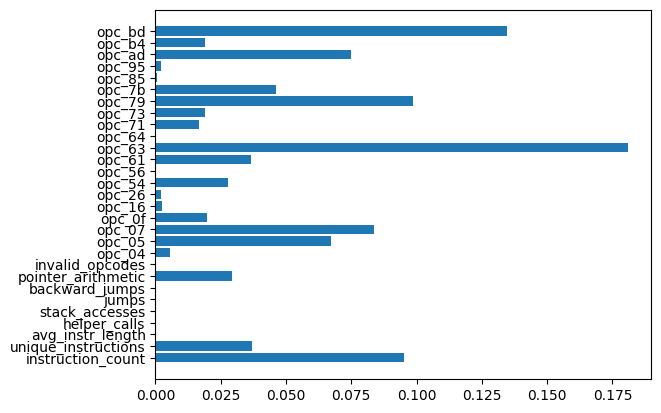

In [49]:
# init random forest
rf = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=1)

# Train the model and predict for test set
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# output results
print("Random Forest Results: ")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Calculate and plot feature importance
importances = rf.feature_importances_
plt.barh(X.columns, importances)
plt.show()

### LSTM (Long Short-Term Memory)

In [50]:
# expand feature matrix to 3-dimensional tensor
X_lstm = np.expand_dims(X.values, axis=-1)

# Train test split for lstm model
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y, test_size=0.3, random_state=1, stratify=y)

# print data shape
print(f"LSTM data shape: {X_train_lstm.shape}")

# Build LSTM model with 64 mem units
model = Sequential([LSTM(64, input_shape=(X_train_lstm.shape[1], 1)), Dense(32, activation="relu"), Dense(1, activation="sigmoid")])

# compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# train the model
history = model.fit(X_train_lstm, y_train_lstm, validation_split=0.2, epochs=25, batch_size=32)

# predict for test set
y_pred_lstm = (model.predict(X_test_lstm) > 0.5).astype(int)

# output results
print("LSTM Results: ")
print("Accuracy:", accuracy_score(y_test_lstm, y_pred_lstm))
print("Precision:", precision_score(y_test_lstm, y_pred_lstm))
print("Recall:", recall_score(y_test_lstm, y_pred_lstm))
print("F1 Score:", f1_score(y_test_lstm, y_pred_lstm))
print("Confusion Matrix:\n", confusion_matrix(y_test_lstm, y_pred_lstm))

LSTM data shape: (210, 29, 1)
Epoch 1/25


C:\Users\Nick\Desktop\ebpf_vuln_detection\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4881 - loss: 0.6841 - val_accuracy: 0.5476 - val_loss: 0.6540
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4881 - loss: 0.6615 - val_accuracy: 0.5476 - val_loss: 0.6391
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5179 - loss: 0.6417 - val_accuracy: 0.6190 - val_loss: 0.6131
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6429 - loss: 0.6135 - val_accuracy: 0.6190 - val_loss: 0.5695
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8512 - loss: 0.5567 - val_accuracy: 0.8810 - val_loss: 0.4825
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8274 - loss: 0.4719 - val_accuracy: 0.8810 - val_loss: 0.3845
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8333 - loss: 0.4379 - val_accuracy: 0.9762 - val_loss: 0.3144
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8155 - loss: 0.3990 - val_accuracy: 0.7381 - val_loss: 0.4397
Epoch 9/25


## Results

### Logistic Regression

The logistic regression model classifies all of the test samples with perfect accuracy. This means that the linear separation of features is capable of identifying vulnerable versus safe programs in the dataset that I generated. However, it is important to mention that the perfect scores here may indicate overfitting or that the dataset is relatively small and the data being synthetically generated. The logistic regression model will benefit from validation from real eBPF code samples.

I attempted to add more complicated and tricky off by one errors into my unsafe code to trick the LR and RF models but did not have any luck. This could either mean that LR and RF models are great for this task or that there are some features that are leaking which file is which from the synthetic sample generation.

### Random Forest

The Random Forest model also classifies all of the test samples with perfect accuracy. This tells us that the non-linear interactions between features in the dataset may not have been necessary to separate the classes. The graph of feature importance shows us that opcode 0x63, 0xbd, 0x79 and instruction count were all important indicators of a program that is vulnerable. This makes sense because those opcodes like 0x63 STXW (Store Register Word) storing memory is inherently riskier than reading due to things like stack buffer overwrites. Total instruction count makes sense because programs with more instructions are more complex and are likely to lead to more vulnerabilites.

Similar to the LR model, the perfect performance is likely due to the dataset being small and synthetically generated.

### LSTM

The LSTM model had a lower performance than the LR and RF models but still had good results (accuracy of about 0.81, precision of 0.78, recall of 0.87 and f1 score of 0.82). LSTM models the sequential nature of eBPF instructions and the results show that this may not be completely necessary in this dataset because the vulnerable files are easily identifiable from other features. The high recall suggests that the model is classifying most of the unsafe programs correctly, but some vulnerable programs slipped through. I suspect that this model will perform better against larger more robust datasets.

## Conclusions

- The LR and the RF models performed with perfect accuracy on this dataset which most likely means there was overfitting either due to the dataset being somewhat small or the dataset being generated synthetically.
- The LSTM model's lower precision and high recall suggests that it is sensitive to vulnerabilities but may overpredict them on limited data.
- Overall, classical ML models are sufficient for this task while sequential deep learning models may perform better against larger and complex datasets.

## Future Work

- Find a way to compile real world safe and unsafe code samples.
- Make the sample generation script more robust to include larger more accurate eBPF code samples.
- Train and compare more ML models like Gradient Boosted Decision Trees, and BiLSTM.
- Classify different types of unsafe code patterns rather than just safe vs unsafe.


### References